<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Filter-function-from-v4_bls_exploration" data-toc-modified-id="Filter-function-from-v4_bls_exploration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Filter function from <code>v4_bls_exploration</code></a></span></li><li><span><a href="#Put-data-in-the-right-shape" data-toc-modified-id="Put-data-in-the-right-shape-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Put data in the right shape</a></span></li><li><span><a href="#Make-plots" data-toc-modified-id="Make-plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Make plots</a></span></li><li><span><a href="#More-graphs" data-toc-modified-id="More-graphs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>More graphs</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## Load data

In [2]:
data = pd.read_parquet("bls_data.parquet")
metadata = pd.read_parquet("bls_metadata.parquet")


In [3]:
metadata["cps_labor_force_status"].unique()

array(['Employed', 'Labor Force Flows Employed to Employed',
       'Labor Force Flows Unemployed to Employed',
       'Labor Force Flows Not in Labor Force to Employed',
       'Marginal Inflows to Employed', 'Unemployed',
       'Labor Force Flows Employed to Unemployed',
       'Labor Force Flows Unemployed to Unemployed',
       'Labor Force Flows Not in Labor Force to Unemployed',
       'Marginal Inflows to Unemployed', 'Not in labor force',
       'Labor Force Flows Employed to Not in Labor Force',
       'Labor Force Flows Unemployed to Not in Labor Force',
       'Labor Force Flows Not in Labor Force to Not in Labor Force',
       'Marginal Inflows to Not in Labor Force',
       'Employed to other Marginal Outflows',
       'Unemployed to other Marginal Outflows',
       'Not in Labor Force to other Marginal Outflows'], dtype=object)

In [4]:
data["value"] = pd.to_numeric(data["value"])

data["dt"] = pd.to_datetime(
    data.apply(lambda x: f"1 {x['periodName']} {x['year']}", axis=1)
)

# Drop unneeded date info
data = data.drop(
    ["year", "periodName", "period"], axis=1
).sort_values(
    ["series_id", "dt"]
)[["series_id", "dt", "value"]]

lfs_status = {
    "Employed": "employed",
    "Unemployed": "unemployed",
    "Not in labor force": "nilf",
    "Labor Force Flows Employed to Employed": "ee",
    "Labor Force Flows Employed to Unemployed": "eu",
    "Labor Force Flows Unemployed to Employed": "ue",
    "Labor Force Flows Unemployed to Unemployed": "uu",               
}

metadata = metadata.replace({"cps_labor_force_status": lfs_status})

and_filters = [
    "(commerce_industry == 'All Industries')",
    "(occupation == 'All Occupations')",
    "(seasonality == 'Not Seasonally Adjusted')",
    "(demographic_race == 'All Races')",
]

metadata_lf = metadata.query(
    "&".join(and_filters)
).loc[metadata["cps_labor_force_status"].isin(lfs_status.values()), :]

df = pd.merge(
    data, metadata_lf[["series_id", "cps_labor_force_status", "demographic_gender"]],
    on="series_id", how="right"
).rename(
    columns={"cps_labor_force_status": "variable"}
)[["variable", "demographic_gender", "dt", "value"]]

df = df.pivot_table(
    index=["dt", "variable"], columns="demographic_gender", values="value"
).rename(
    columns={"Both Sexes": "all", "Men": "men", "Women": "women"}
).reset_index()


## Filter function from `v4_bls_exploration`

In [5]:
def filter_days_from(data, start_date, ndays=3*365):
    """
    Creates a history of data starting at a particular date and running
    forward for `ndays` days.
    
    Parameters
    ----------
    data : pd.DataFrame
        A DataFrame with relevant data that we'd like to consider
        starting from a particular date. Must have a column `dt` with
        datetime data
    start_date : str or datetime
        The moment we would like our history to start
    ndays : int
        The number of days that we would like to keep in our history
    
    Returns
    -------
    out : pd.DataFrame
        A copy of `data` with only data from `start_date` to
        `start_date + f'{ndays} days'` and a new column that counts
        the number of days since `start_date`
    """
    # Determine number of days from certain date
    days_from = (data["dt"] - pd.to_datetime(start_date)).dt.days
    
    # Check for >=0 days and <ndays
    dates_to_keep = (days_from >= 0) & (days_from < ndays)
    
    # Create copy of DataFrame that we'll use as the return
    out = data.copy()
    out["days_from"] = days_from
    out = out.loc[dates_to_keep, :]

    return out.reset_index(drop=True)

## Put data in the right shape

In [6]:
def clean_and_pivot_data(df):
    foo = df.pivot(index="days_from", columns="variable", values="value")
    foo["eu"] = foo.eval("eu / employed")
    foo["ue"] = foo.eval("ue / unemployed")
    
    return foo.loc[:, ["eu", "ue"]]

def split_by_sex(df):
    df_bs = clean_and_pivot_data(
        df.loc[:, ["days_from", "dt", "variable", "all"]].rename(
            columns={"all": "value"}
        )
    )
    df_m = clean_and_pivot_data(
        df.loc[:, ["days_from", "dt", "variable", "men"]].rename(
            columns={"men": "value"}
        )
    )
    df_w = clean_and_pivot_data(
        df.loc[:, ["days_from", "dt", "variable", "women"]].rename(
            columns={"women": "value"}
        )
    )
    
    return df_bs, df_m, df_w

In [7]:
df_covid = filter_days_from(
    df, "2019-03-01", 5*365
)

df_covid_bs, df_covid_m, df_covid_w = split_by_sex(df_covid)

df_gr = filter_days_from(
    df, "2007-02-01", 5*365
)

df_gr_bs, df_gr_m, df_gr_w = split_by_sex(df_gr)

In [8]:
df_covid.query(
    "variable == 'employed' | variable == 'unemployed'"
).loc[
    :, ["dt", "variable", "all"]
].pivot_table(
    index="dt", columns="variable", values="all"
).sum(axis=1)

dt
2019-03-01    162823
2019-04-01    162097
2019-05-01    162655
2019-06-01    164120
2019-07-01    164941
2019-08-01    164019
2019-09-01    163943
2019-10-01    164577
2019-11-01    164386
2019-12-01    164007
2020-01-01    163498
2020-02-01    164235
2020-03-01    162537
2020-04-01    155830
2020-05-01    157975
2020-06-01    160883
2020-07-01    161374
2020-08-01    160966
2020-09-01    160073
2020-10-01    161053
2020-11-01    160467
2020-12-01    160017
dtype: int64

## Make plots

In [9]:
mcolor = "#138bb0"
wcolor = "#c10ac4"


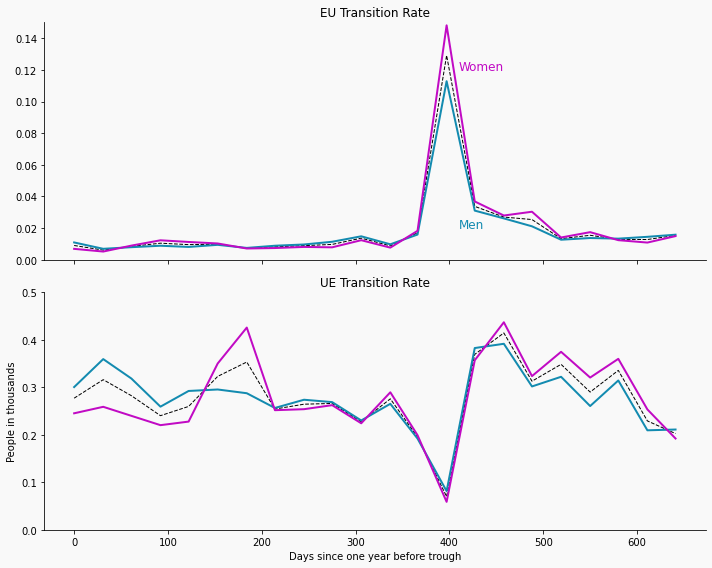

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

df_covid_bs.plot(
    y="eu", ax=ax[0],
    color="k", linestyle="--", linewidth=1.0, legend=False
)
df_covid_m.plot(
    y="eu", ax=ax[0],
    color=mcolor, linestyle="-", linewidth=2.0, legend=False
)
df_covid_w.plot(
    y="eu", ax=ax[0],
    color=wcolor, linestyle="-", linewidth=2.0, legend=False
)

df_covid_bs.plot(
    y="ue", ax=ax[1],
    color="k", linestyle="--", linewidth=1.0, legend=False
)
df_covid_m.plot(
    y="ue", ax=ax[1],
    color=mcolor, linestyle="-", linewidth=2.0, legend=False
)
df_covid_w.plot(
    y="ue", ax=ax[1],
    color=wcolor, linestyle="-", linewidth=2.0, legend=False
)


ax[0].set_title("EU Transition Rate")
ax[1].set_title("UE Transition Rate")
ax[1].set_xlabel("Days since one year before trough")
ax[1].set_ylabel("People in thousands")

for _ax in ax:
    _ax.spines["right"].set_visible(False)
    _ax.spines["top"].set_visible(False)
    _ax.set_facecolor((0.975, 0.975, 0.975))

fig.set_facecolor((0.975, 0.975, 0.975))
    
ax[0].annotate("Men", (410, 0.02), color=mcolor, size=12)
ax[0].annotate("Women", (410, 0.12), color=wcolor, size=12)

ax[0].set_ylim(0.0, 0.15)
ax[1].set_ylim(0.0, 0.5)

fig.tight_layout()

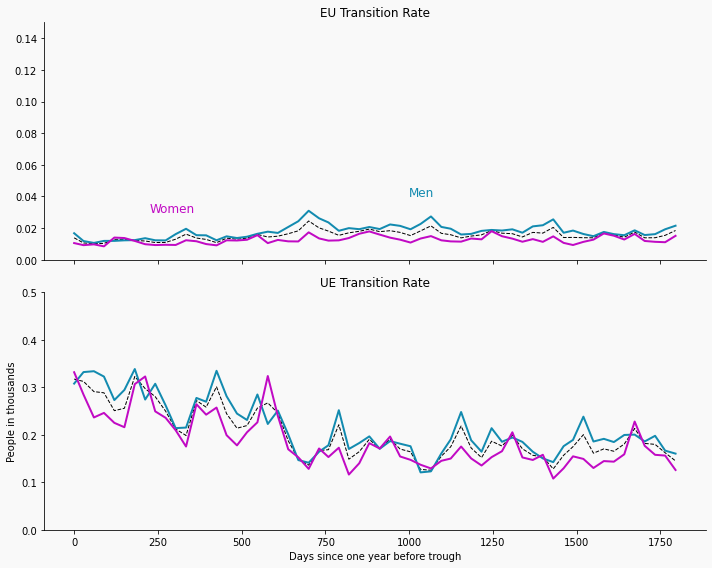

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

df_gr_bs.plot(
    y="eu", ax=ax[0],
    color="k", linestyle="--", linewidth=1.0, legend=False
)
df_gr_m.plot(
    y="eu", ax=ax[0],
    color=mcolor, linestyle="-", linewidth=2.0, legend=False
)
df_gr_w.plot(
    y="eu", ax=ax[0],
    color=wcolor, linestyle="-", linewidth=2.0, legend=False
)

df_gr_bs.plot(
    y="ue", ax=ax[1],
    color="k", linestyle="--", linewidth=1.0, legend=False
)
df_gr_m.plot(
    y="ue", ax=ax[1],
    color=mcolor, linestyle="-", linewidth=2.0, legend=False
)
df_gr_w.plot(
    y="ue", ax=ax[1],
    color=wcolor, linestyle="-", linewidth=2.0, legend=False
)


ax[0].set_title("EU Transition Rate")
ax[1].set_title("UE Transition Rate")
ax[1].set_xlabel("Days since one year before trough")
ax[1].set_ylabel("People in thousands")

for _ax in ax:
    _ax.spines["right"].set_visible(False)
    _ax.spines["top"].set_visible(False)
    _ax.set_facecolor((0.975, 0.975, 0.975))

fig.set_facecolor((0.975, 0.975, 0.975))
    
ax[0].annotate("Men", (1000, 0.04), color=mcolor, size=12)
ax[0].annotate("Women", (225, 0.03), color=wcolor, size=12)

ax[0].set_ylim(0.0, 0.15)
ax[1].set_ylim(0.0, 0.5)

fig.tight_layout()

## More graphs

<AxesSubplot:xlabel='days_from'>

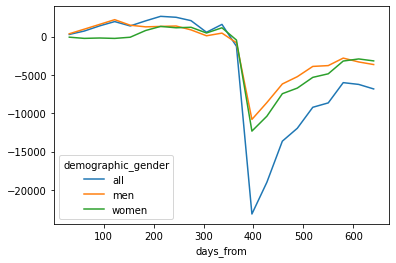

In [12]:
df_covid.query(
    "variable == 'employed'"
).reset_index(
    drop=True
).set_index(
    "days_from"
).loc[
    :, ["all", "men", "women"]
].diff().cumsum().plot()